## Health Insurance Company Provides Car Insureanse for already clients
There are an Health Insurance company that wants to offer an aditional service to their clients, which is a Car Insurance service. And, trying to offer only for the most posible clients to aquire the service they want a platform that can predict which clients has these kind of "perfil"

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_val_predict

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier as dtc
from xgboost import XGBClassifier as xgb
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.metrics import classification_report, accuracy_score, recall_score, roc_curve, auc

In [2]:
# Reading the da base
df = pd.read_csv('/Users/Caio/Documents/MeusProjetos/HICSP/dataset/train.csv', sep=',')

In [3]:
# Seeing the data
df.head(5)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28,0,> 2 Years,Yes,40454,26,217,1
1,2,Male,76,1,3,0,1-2 Year,No,33536,26,183,0
2,3,Male,47,1,28,0,> 2 Years,Yes,38294,26,27,1
3,4,Male,21,1,11,1,< 1 Year,No,28619,152,203,0
4,5,Female,29,1,41,1,< 1 Year,No,27496,152,39,0


In [4]:
# Obtaining some informations about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    381109 non-null  int64 
 1   gender                381109 non-null  object
 2   age                   381109 non-null  int64 
 3   driving_license       381109 non-null  int64 
 4   region_code           381109 non-null  int64 
 5   previously_insured    381109 non-null  int64 
 6   vehicle_age           381109 non-null  object
 7   vehicle_damage        381109 non-null  object
 8   annual_premium        381109 non-null  int64 
 9   policy_sales_channel  381109 non-null  int64 
 10  vintage               381109 non-null  int64 
 11  response              381109 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 34.9+ MB


In [5]:
# initial information of the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0
age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0
driving_license,381109.0,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0
region_code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0
previously_insured,381109.0,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0
annual_premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0
policy_sales_channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0
vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0
response,381109.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0


In [6]:
# Searching for null values
df.isnull().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

In [7]:
# dropping the 'id' column, his informations are not important for the development of models
df = df.drop(columns = 'id')

In [8]:
# checking duplicated data
df.duplicated().sum()

269

In [9]:
# about column Vehicle_Age, checking it content for preprocessing
df.vehicle_age.unique()

array(['> 2 Years', '1-2 Year', '< 1 Year'], dtype=object)

In [10]:
# Applying an OneHotEncoder into some columns that presents string content
df['vehicle_age'] = df['vehicle_age'].map({'< 1 Year':0, '1-2 Year':1, '> 2 Years':2}).astype(int)

In [11]:
df['gender'] = df['gender'].map({'Male':0, 'Female':1}).astype(int)

In [12]:
df['vehicle_damage'] = df['vehicle_damage'].map({'No':0, 'Yes':1}).astype(int)

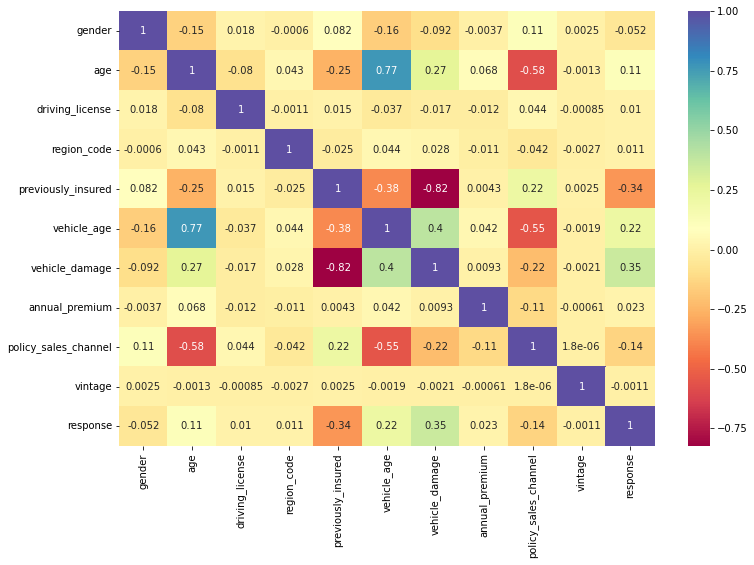

In [13]:
# correlation visualization of the data
plt.figure(figsize=((12,8)))
sns.heatmap(df.corr(), cmap='Spectral', annot=True)

In [14]:
# Preparação para análise de informações mutuas
x = df.drop(columns='response')
y = df['response']

In [15]:
def make_mi_score(x, y):
    """Applycation of Mutual Information on a dataset
    
    Args:
        x: Data that Mutual Information will be applyed.
        y: Data used as 'reference' for the Mutual Information.
    
    """
    mi_score = mutual_info_classif(x, y, discrete_features='auto')
    mi_score = pd.Series(mi_score, index=x.columns)
    mi_score = mi_score.sort_values(ascending=False)
    return mi_score

In [16]:
# Applying the Mutual Information of the data set.
mi_scores = make_mi_score(x, y)
mi_scores

previously_insured      0.098445
vehicle_damage          0.093529
driving_license         0.074881
policy_sales_channel    0.058706
vehicle_age             0.043741
age                     0.031976
gender                  0.018208
region_code             0.014242
annual_premium          0.002984
vintage                 0.000000
dtype: float64

In [17]:
# Obtaining the data with a Mutual Information greater them 0.01
x1 = x.loc[:, mi_scores > 0.01]
x1.shape

(381109, 8)

### Development of some models for client prediction
The classification models that will be used in here are: Logistic Regression, KNN, K-Means, Naive-Bayes, Decision Tree and Random Forest. The methods will be compred between them, also the data sets with and without mutual information higher scores.

Each models will have the metrics accuracy and recall values stored in variables for future comparison, this will help to see the changes between models and wich one can be the best for this classification.

#### Developin the models with the dataset without Mutual Information.

In [18]:
def data_extrac(pred, name, models, acc, rec, y):
    """ Extract info from cross_val_predict
    
    Args:
        pred: Prediction data from cross validation prediction
        name: Model name
        models: list that stores the model's name
        acc: list that stores the model's accuracy
        rec: list that stores the model's recall
        y: array used to validate the model
    """
    models.append(name)
    acc.append(accuracy_score(y, pred))
    rec.append(recall_score(y, pred))
    print('Classification report: \n', classification_report(y, pred))

In [19]:
def roc_calc_curve(pred, y, name):

    '''
    Compute ROC curve and ROC area for each class and generates the figure with the curve.

    Args:
        pred: prediction data from cross validation prediction
        y: array used to validate the model
        name: model name (str)
    
    '''
    fpr, tpr, _ = roc_curve(y, pred)
    #roc_auc = auc(fpr, tpr)

    '''# Compute micro-average ROC curve and ROC area - Achar um jeito de isso funcionar***
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), pred_lr.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])'''

    plt.plot(fpr, tpr, color='red', label=name)
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()


In [20]:
# Variables to store the metrics scores
models, acc, rec = [], [], []

### Logistic Regression

In [21]:
lr = LogisticRegression()
lr.fit(x, y)

pred_lr = cross_val_predict(estimator=lr, X = x, y = y, cv = 5)
data_extrac(pred_lr, 'Logistic Regretion', models, acc, rec, y)
roc_calc_curve(pred_lr, y, 'LogisticRegression')

C:\Users\Caio\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Caio\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Classification report: 
               precision    recall  f1-score   support

           0       0.88      1.00      0.93    334399
           1       0.00      0.00      0.00     46710

    accuracy                           0.88    381109
   macro avg       0.44      0.50      0.47    381109
weighted avg       0.77      0.88      0.82    381109



C:\Users\Caio\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### KNN

In [23]:
knn = KNeighborsClassifier()
knn.fit(x, y)

pred_knn = cross_val_predict(estimator=knn, X = x, y = y, cv=5)
data_extrac(pred_knn, 'KNN', models, acc, rec, y)
roc_calc_curve(pred_knn, y, 'KNN')

Classification report: 
               precision    recall  f1-score   support

           0       0.88      0.97      0.92    334399
           1       0.21      0.06      0.09     46710

    accuracy                           0.86    381109
   macro avg       0.55      0.51      0.51    381109
weighted avg       0.80      0.86      0.82    381109



### K-Means

In [24]:
km = KMeans(n_clusters=2)
km.fit(x, y)

pred_km = cross_val_predict(estimator=km, X = x, y = y, cv=5)
data_extrac(pred_km, 'K-Means', models, acc, rec, y)
roc_calc_curve(pred_km, y, 'K-Means')

Classification report: 
               precision    recall  f1-score   support

           0       0.88      0.69      0.77    334399
           1       0.12      0.32      0.18     46710

    accuracy                           0.64    381109
   macro avg       0.50      0.50      0.47    381109
weighted avg       0.79      0.64      0.70    381109



### Naive-Bayes

In [25]:
nb = GaussianNB()
nb.fit(x, y)

pred_nb = cross_val_predict(estimator=nb, X = x, y = y, cv=5)
data_extrac(pred_nb, 'Naive-Bayes', models, acc, rec, y)
roc_calc_curve(pred_nb, y, 'Naive-Bayes')

Classification report: 
               precision    recall  f1-score   support

           0       0.91      0.88      0.90    334399
           1       0.30      0.36      0.33     46710

    accuracy                           0.82    381109
   macro avg       0.61      0.62      0.61    381109
weighted avg       0.83      0.82      0.83    381109



### Decision Tree

In [26]:
dt = dtc()
dt.fit(x, y)

pred_dt = cross_val_predict(estimator=dt, X = x, y = y, cv=5)
data_extrac(pred_dt, 'Decision Tree', models, acc, rec, y)
roc_calc_curve(pred_dt, y, 'Decision Tree')

Classification report: 
               precision    recall  f1-score   support

           0       0.90      0.89      0.90    334399
           1       0.29      0.31      0.30     46710

    accuracy                           0.82    381109
   macro avg       0.60      0.60      0.60    381109
weighted avg       0.83      0.82      0.83    381109



### Random Forest

In [27]:
rf = rfc()
rf.fit(x, y)

pred_rf = cross_val_predict(estimator=rf, X = x, y = y, cv=5)
data_extrac(pred_rf, 'Random Forest', models, acc, rec, y)
roc_calc_curve(pred_rf, y, 'Random Forest')

Classification report: 
               precision    recall  f1-score   support

           0       0.89      0.97      0.93    334399
           1       0.36      0.12      0.18     46710

    accuracy                           0.87    381109
   macro avg       0.63      0.55      0.55    381109
weighted avg       0.82      0.87      0.84    381109



### XGBOOST

In [28]:
xgb_model = xgb()
xgb_model.fit(x, y, eval_metric='mlogloss')

pred_xgb = cross_val_predict(estimator=xgb_model, X = x, y = y, cv=5)
data_extrac(pred_xgb, 'XGBOOST', models, acc, rec, y)
roc_calc_curve(pred_xgb, y, 'XGBOOST')

C:\Users\Caio\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Caio\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:56:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Caio\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:56:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Caio\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:57:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Caio\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:57:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Caio\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:58:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classification report: 
               precision    recall  f1-score   support

           0       0.88      1.00      0.93    334399
           1       0.46      0.03      0.05     46710

    accuracy                           0.88    381109
   macro avg       0.67      0.51      0.49    381109
weighted avg       0.83      0.88      0.83    381109



### Metrics comparison (Adicionar um titulo geral de indicando a base de dados)

([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text major ticklabel objects>)

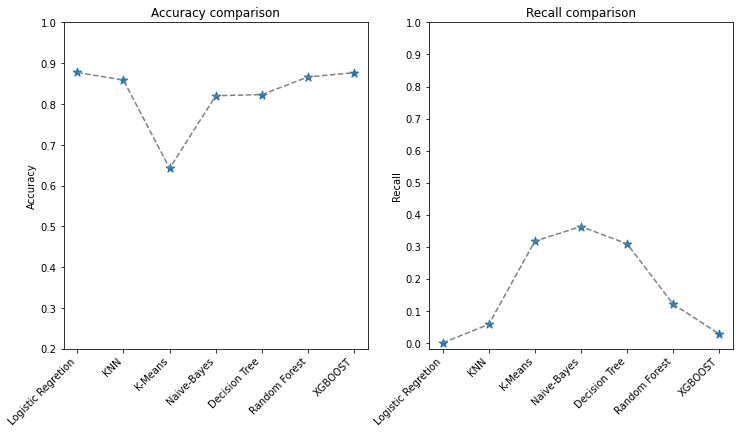

In [29]:
# Figure that compares de metrics of each model
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(models, acc, marker = '*', s=80)
plt.plot(models, acc, 'b--', color='gray')
plt.title('Accuracy comparison')
plt.ylabel('Accuracy')
plt.yticks(np.arange(0.2, 1.01, 0.1))
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
plt.scatter(models, rec, marker = '*', s=80)
plt.plot(models, rec, 'b--', color='gray')
plt.title('Recall comparison')
plt.ylabel('Recall')
plt.yticks(np.arange(0, 1.01, 0.1))
plt.xticks(rotation=45, ha='right')

#### Developin the models with the dataset with Mutual Information.

In [30]:
# Variables used to store metrics scores
models1, acc1, rec1 = [], [], []

### Logistic Regression

In [31]:
lr_mi = LogisticRegression()
lr_mi.fit(x1, y)

pred_lr1 = cross_val_predict(estimator=lr_mi, X = x1, y = y, cv=5)
data_extrac(pred_lr1, 'Logistic Regretion', models1, acc1, rec1, y)
roc_calc_curve(pred_lr1, y, 'LogisticRegression')

C:\Users\Caio\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Caio\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Classification report: 
               precision    recall  f1-score   support

           0       0.88      1.00      0.93    334399
           1       0.34      0.00      0.01     46710

    accuracy                           0.88    381109
   macro avg       0.61      0.50      0.47    381109
weighted avg       0.81      0.88      0.82    381109



### KNN

In [32]:
knn_mi = KNeighborsClassifier()
knn_mi.fit(x1, y)

pred_knn1 = cross_val_predict(estimator=knn_mi, X = x1, y = y, cv=5)
data_extrac(pred_knn1, 'KNN', models1, acc1, rec1, y)
roc_calc_curve(pred_knn1, y, 'KNN')

Classification report: 
               precision    recall  f1-score   support

           0       0.89      0.95      0.92    334399
           1       0.34      0.17      0.23     46710

    accuracy                           0.86    381109
   macro avg       0.61      0.56      0.57    381109
weighted avg       0.82      0.86      0.84    381109



### K-Means

In [33]:
km_mi = KMeans(n_clusters=2)
km_mi.fit(x1, y)

pred_km1 = cross_val_predict(estimator=km_mi, X = x1, y = y, cv=5)
data_extrac(pred_km1, 'K-Means', models1, acc1, rec1, y)
roc_calc_curve(pred_km1, y, 'K-Means')

Classification report: 
               precision    recall  f1-score   support

           0       0.89      0.65      0.75    334399
           1       0.15      0.44      0.22     46710

    accuracy                           0.62    381109
   macro avg       0.52      0.54      0.49    381109
weighted avg       0.80      0.62      0.69    381109



### Naive-Bayes

In [34]:
nb_mi = GaussianNB()
nb_mi.fit(x1, y)

pred_nb1 = cross_val_predict(estimator=nb_mi, X = x1, y = y, cv=5)
data_extrac(pred_nb1, 'Naive-Bayes', models1, acc1, rec1, y)
roc_calc_curve(pred_nb1, y, 'Naive-Bayes')

Classification report: 
               precision    recall  f1-score   support

           0       0.99      0.59      0.74    334399
           1       0.25      0.98      0.40     46710

    accuracy                           0.64    381109
   macro avg       0.62      0.78      0.57    381109
weighted avg       0.90      0.64      0.70    381109



### Decision Tree

In [35]:
dt_mi = dtc()
dt_mi.fit(x1, y)

pred_dt1 = cross_val_predict(estimator=dt_mi, X = x1, y = y, cv=5)
data_extrac(pred_dt1, 'Decision Tree', models1, acc1, rec1, y)
roc_calc_curve(pred_dt1, y, 'Decision Tree')

Classification report: 
               precision    recall  f1-score   support

           0       0.89      0.97      0.92    334399
           1       0.32      0.11      0.17     46710

    accuracy                           0.86    381109
   macro avg       0.60      0.54      0.55    381109
weighted avg       0.82      0.86      0.83    381109



### Random Forest

In [36]:
rf_mi = rfc()
rf_mi.fit(x1, y)

pred_rf1 = cross_val_predict(estimator= rf_mi, X = x1, y = y, cv = 5)
data_extrac(pred_rf1, 'Random Forest', models1, acc1, rec1, y)
roc_calc_curve(pred_rf1, y, 'Random Forest')

Classification report: 
               precision    recall  f1-score   support

           0       0.89      0.97      0.93    334399
           1       0.34      0.12      0.18     46710

    accuracy                           0.86    381109
   macro avg       0.62      0.55      0.55    381109
weighted avg       0.82      0.86      0.83    381109



([0, 1, 2, 3, 4, 5], <a list of 6 Text major ticklabel objects>)

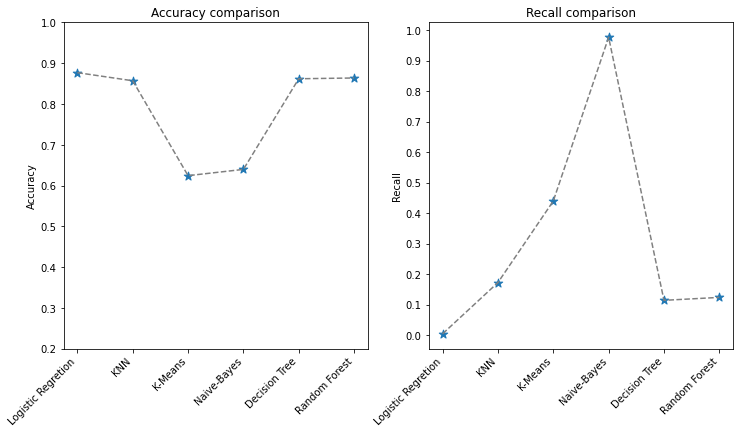

In [37]:
# Figure that compares de metrics of each model with multual information
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(models1, acc1, marker = '*', s=80)
plt.plot(models1, acc1, 'b--', color='gray')
plt.title('Accuracy comparison')
plt.ylabel('Accuracy')
plt.yticks(np.arange(0.2, 1.01, 0.1))
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
plt.scatter(models1, rec1, marker = '*', s=80)
plt.plot(models1, rec1, 'b--', color='gray')
plt.title('Recall comparison')
plt.ylabel('Recall')
plt.yticks(np.arange(0, 1.01, 0.1))
plt.xticks(rotation=45, ha='right')

([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text major ticklabel objects>)

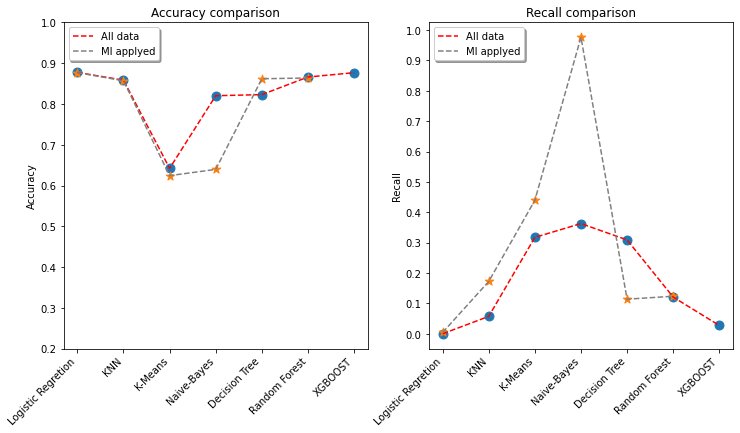

In [38]:
# Figure that compares de metrics of all models
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(models, acc, marker = 'o', s=80)
plt.plot(models, acc, 'b--', color='red')
plt.scatter(models1, acc1, marker = '*', s=80)
plt.plot(models1, acc1, 'b--', color='gray')
plt.legend(('All data', 'MI applyed'), loc='upper left', shadow=True)
plt.title('Accuracy comparison')
plt.ylabel('Accuracy')
plt.yticks(np.arange(0.2, 1.01, 0.1))
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
plt.scatter(models, rec, marker = 'o', s=80)
plt.plot(models, rec, 'b--', color='red')
plt.scatter(models1, rec1, marker = '*', s=80)
plt.plot(models1, rec1, 'b--', color='gray')
plt.legend(('All data', 'MI applyed'), loc='upper left', shadow=True)
plt.title('Recall comparison')
plt.ylabel('Recall')
plt.yticks(np.arange(0, 1.01, 0.1))
plt.xticks(rotation=45, ha='right')